In [1]:
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display,Markdown
from analise_obras_df.analise import verifica_coluna
from analise_obras_df.analise import sugere_conversao

## 1. Extração de Dados

O serviço da API é disponibilizado pela plataforma ObrasGov.br como uma solução tecnológica para a melhoria da governança dos investimentos federais em infraestrutura, por meio do acompanhamento e do monitoramento da execução dos investimentos em projetos de infraestrutura do Governo Federal. A plataforma reúne informações acerca:

- Dados dos projetos de investimentos em infraestrutura;
- Dados dos de georreferenciamento projetos de investimentos em infraestrutura;
- Dados da Execução Física;
- Dados de Execução Financeira;

Para esse projeto, serão utilizados especificamente dados do endpoint "/projeto-investimento", com filtragem focada em informações sobre o Distrito Federal (DF).

Para mais informações relevantes sobre a API acesso disponível em [ObrasGov.br](https://api.obrasgov.gestao.gov.br/obrasgov/api/swagger-ui/index.html#/Projeto%20De%20Investimento/buscarPorFiltro)


No bloco abaixo organiza-se a URL base, endpoint e filtros. Tendo o endereço como base, é feita a requisição (GET).

In [2]:
URL_BASE = "https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento"
params_request = {
    'uf': "DF",
    'pagina': 0,
    'tamanhoDaPagina': 100,
    'ordenacao': 'ID_UNICO'
}
db_total = []
db_metadados = []
max_retries = 5
count_retries = 0
print(f"Iniciando requisição para API com os parametros: {params_request}")

while True:
    try:
        response = requests.get(URL_BASE, params = params_request)
        print(f"Requisitando dados da url: {response.url}")

        response.raise_for_status()

        pagina = response.json()
        metadados_da_pagina = pagina.copy()
        metadados_da_pagina.pop('content', None)
        db_metadados.append(metadados_da_pagina)

        

        if pagina['content']:
            db_total.extend(pagina['content'])
            print(f"Conteúdo da pagina {params_request['pagina']} coletado com sucesso. Total de obras acumuladas {len(db_total)}")

        else:
            print(f"Nenhum resultado encontrado na pagina {params_request['pagina']}. Extração completa")
            break

        print(f"Atualizando pagina {params_request['pagina']} -> {params_request['pagina']+1}")
        params_request['pagina'] += 1
        count_retries = 0
        time.sleep(20)

    except requests.exceptions.HTTPError as http_erro:
        status_code = http_erro.response.status_code
        count_retries += 1

        if count_retries > max_retries:
            print("Finalizando processo de extraçao por excesso de erros.")
            break

        if status_code == 429:
            time_sleep = 60 * count_retries
            print(f"Servidor retornando erro {status_code} - Muitas requisições. Aguardando {time_sleep} segundos para nova tentativa")
            time.sleep(time_sleep)
            continue
        elif status_code >= 500:
            time_sleep = 60
            print(f"Servidor retornando erro {status_code} - Erro no servidor. Aguardando {time_sleep} segundos para nova tentativa")
            time.sleep(time_sleep)
            continue
        else:
            print(f"Erro HTTP inesperado: {http_erro}. Finalizando processo de extração.")
            break

    except requests.exceptions.RequestException as erro:
        print(f"Ocorreu um erro no processo de requisição: <{erro} >")
        print(f"Processo de extração interrompido na pagina {params_request['pagina']}")
        break

Iniciando requisição para API com os parametros: {'uf': 'DF', 'pagina': 0, 'tamanhoDaPagina': 100, 'ordenacao': 'ID_UNICO'}
Requisitando dados da url: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=0&tamanhoDaPagina=100&ordenacao=ID_UNICO
Conteúdo da pagina 0 coletado com sucesso. Total de obras acumuladas 100
Atualizando pagina 0 -> 1
Requisitando dados da url: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=1&tamanhoDaPagina=100&ordenacao=ID_UNICO
Conteúdo da pagina 1 coletado com sucesso. Total de obras acumuladas 200
Atualizando pagina 1 -> 2
Requisitando dados da url: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=2&tamanhoDaPagina=100&ordenacao=ID_UNICO
Servidor retornando erro 429 - Muitas requisições. Aguardando 30 segundos para nova tentativa
Requisitando dados da url: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=2&tamanhoDaPagina=100&ord

### 1.1 Armazenamento (RAW)

 Nesse primeiro momento, os dados recebidos da requisição, serão armazenados em seu estado bruto, sem nenhum tratamento, na pasta 1-raw/

In [3]:
raw_path = "../data/1-raw/"
json_file = "obras_df_raw.json"

meta_path = "../data/1-raw/"
meta_file = "obras_df_metadados.json"

try:
    with open (raw_path+json_file, 'w', encoding = 'utf-8') as f:
        json.dump(db_total, f, ensure_ascii=False, indent=4)
        display(Markdown((f"Dados brutos armazenados com sucesso. Arquivo: {json_file}")))
        
except Exception as e:
    print(f"Erro ao armazenar dados brutos: <{e}>")


with open (meta_path+meta_file, 'w', encoding = 'utf-8') as f:
    json.dump(db_metadados, f, ensure_ascii=False, indent=4)
    display(Markdown((f"Metadados armazenados com sucesso. Arquivo: {meta_file}")))

Dados brutos armazenados com sucesso. Arquivo: obras_df_raw.json

Metadados armazenados com sucesso. Arquivo: obras_df_metadados.json

### 1.2 Carga e Estruturação dos Dados em um DataFrame
Com os dados brutos devidamente armazenados, o próximo bloco é responsável por carregá-los em uma estrutura de dados que nos permita manipulá-los e analisá-los de forma eficiente. Para isso, utilizou-se a biblioteca `pandas` para converter a lista de obras em um **DataFrame**. 

In [3]:
raw_path = "../data/1-raw/"
json_file = "obras_df_raw.json"
try: 
    with open(raw_path+json_file, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)

    obras_DF = raw_data
    df = pd.DataFrame(obras_DF)

    display(Markdown(("Dados carregados na dataframe com sucesso")))

except FileNotFoundError:
    print("Arquivo não encontrado")

except Exception as e:
    print(f"Erro encontrado: <{e}>")

Dados carregados na dataframe com sucesso

## 2. Busca exploratória dos dados

Esse tópico refere-se ao entendimento dos dados e contará com a abordagem descrita pela metodologia [**CRISP-DM**](https://www.datascience-pm.com/crisp-dm-2/) em seu tópico [**II. Data Understanding**](https://www.ibm.com/think/insights/data-quality-metrics). Portanto, após a etapa de coleta inicial dos dados, serão implementados os seguintes processos:
- **Descrição dos Dados**: Nesse momento a database será examinada a fim de trazer suas propriedades superficiais. Métricas de qualidade de dados abordadas:
- **Exploração dos Dados e Verificação da Qualidade dos Dados**: Etapa responsável por uma análise mais profunda, considerando as relações, regras de negócio e contexto aos quais os dados estão inseridos.
  
Para o processo de verificação da qualdiade dos Dados, a database será submetida a verificações, tomando como base as métricas de qualidade apresentadas por documentações disponibilizadas pela **IBM**:
- **Data accuracy**: Data correctly represents real-world events and values.
- **Data completeness**: Data contains all necessary records with no missing values.
- **Data consistency**: Data is coherent and standardized across the organization, ensuring that data records in different datasets are compatible.
- **Data timeliness**: Data values are up to date, allowing organizations to avoid making decisions based on stale information.
- **Data uniqueness**: Data is free from redundancies or duplicate records, which can distort analysis.
- **Data validity**: Data conforms to business rules, such as falling within permitted ranges for certain data values and meeting specified data format standards.

Os processos mencionados acima serão organizados em duas fases principais de análise: **Análise Macroscópica**, a qual contém o processo de **Descriçao dos Dados** e **Análise Microscópica**, que englobará a **Exploração** e **Verificação da Qualidade** dos dados.

### 2.1 Análise Macroscópica


### 2.1.1 Dimensões do Dataframe
- **Total de Registros**: 834
- **Total de Colunas**: 31


### 2.1.2 Dicionário de Dados

,tipo,Valores Nulos
dataFinalEfetiva,object,827
dataInicialEfetiva,object,804
observacoesPertinentes,object,709
populacaoBeneficiada,object,670
qdtEmpregosGerados,object,668
descPopulacaoBeneficiada,object,664
naturezaOutras,object,629
descPlanoNacionalPoliticaVinculado,object,558
cep,object,445
endereco,object,406


### 2.1.3 Análise de Completude Geral

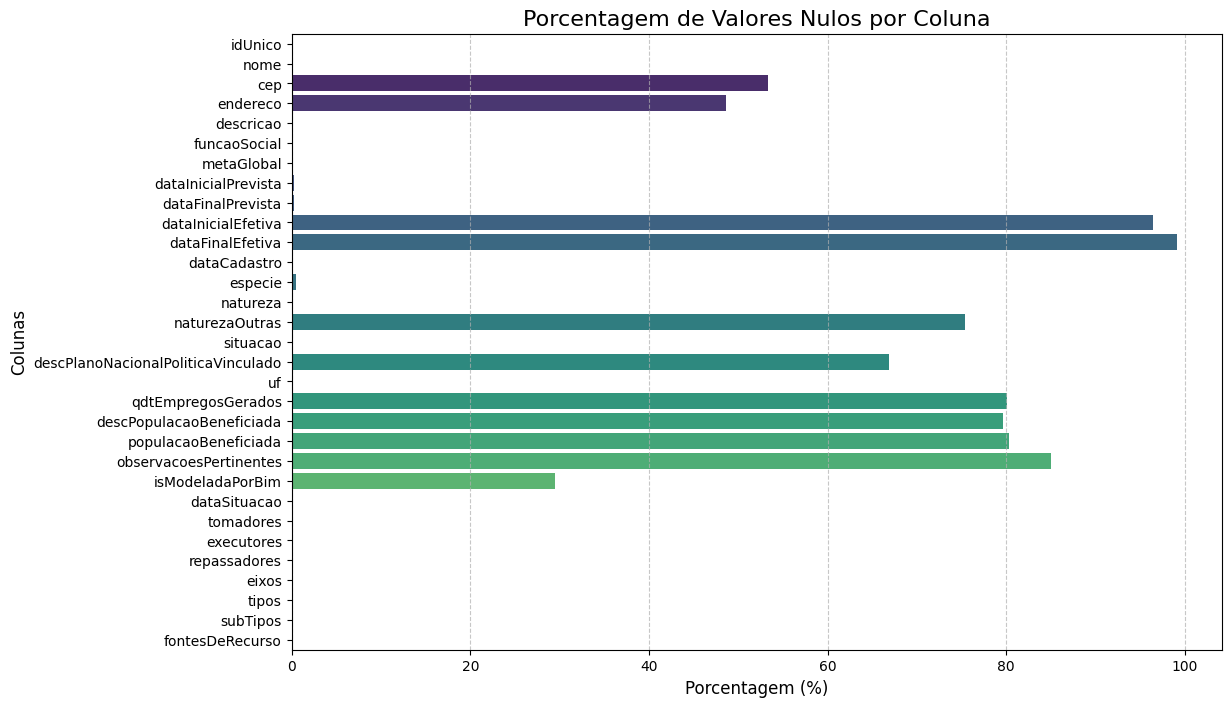

### 2.1.4 Análise de Unicidade Geral

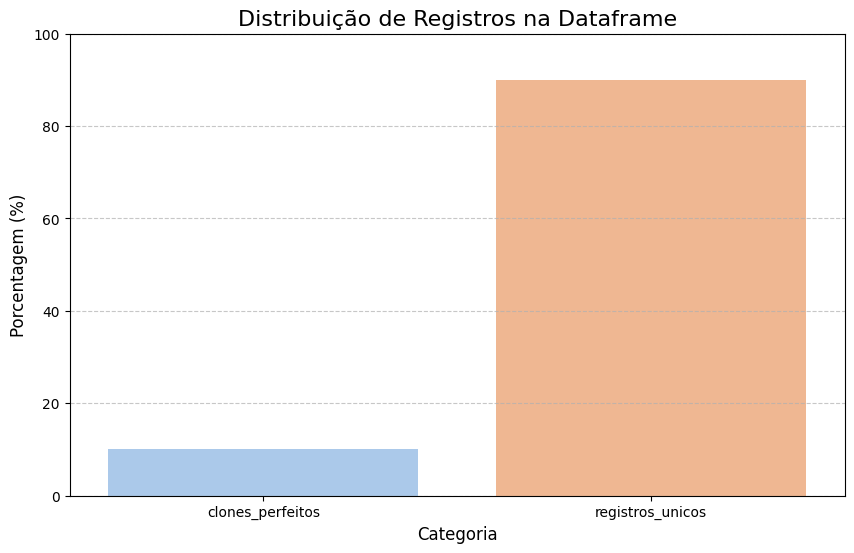

Registros únicos: 750 (89.93%) 

 Registros duplicados: 84 (10.07%)

In [4]:
nulos_por_coluna = {}
df_temp = df.copy()
colunas_unhashble = []
for coluna in df.columns:
    # Verifica colunas com características unhashble
    if df[coluna].apply(lambda x: isinstance(x, (list, dict))).any():
        # Converte a coluna para string para permitir a verificação de duplicatas
        df_temp[coluna] = df_temp[coluna].astype('string')
        colunas_unhashble.append(coluna)
    # Verifica coluna por coluna a quantidade de valores nulos
    nulos_por_coluna[coluna] = df[coluna].isnull().sum()

# Gera nova dataframe sem as linhas que são clones perfeitos
indices_limpos = df_temp.drop_duplicates().index
df_limpa = df.loc[indices_limpos]

# Apresentação dos resultados

dicionario_df = pd.DataFrame(index=df.columns)
dicionario_df['tipo'] = df.dtypes
dicionario_df['Valores Nulos'] = nulos_por_coluna.values()

nulos_series = pd.Series(nulos_por_coluna)
porcentagem_nulos = (nulos_series / len(df)) * 100

distribuicao_df = {}
distribuicao_df['clones_perfeitos'] = (len(df) - len(df_limpa)) / len(df) * 100
distribuicao_df['registros_unicos'] = (len(df_limpa)/ len(df) * 100)

display(Markdown((f"""
### 2.1.1 Dimensões do Dataframe
- **Total de Registros**: {len(df)}
- **Total de Colunas**: {len(df.columns)}
"""
)))
display(Markdown(f"### 2.1.2 Dicionário de Dados"))
display(dicionario_df.sort_values(by='Valores Nulos', ascending=False))


display(Markdown(f"### 2.1.3 Análise de Completude Geral"))
plt.figure(figsize=(12, 8))
sns.barplot(x=porcentagem_nulos.values, y=nulos_series.index, hue=nulos_series.index, orient='h', palette='viridis', legend=False)
plt.title('Porcentagem de Valores Nulos por Coluna', fontsize=16)
plt.xlabel('Porcentagem (%)', fontsize=12)
plt.ylabel('Colunas', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

display(Markdown(f"### 2.1.4 Análise de Unicidade Geral"))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(distribuicao_df.keys()), y=list(distribuicao_df.values()), hue=list(distribuicao_df.keys()), palette='pastel', legend=False)
plt.title('Distribuição de Registros na Dataframe', fontsize=16)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

display(Markdown(f"Registros únicos: {len(df_limpa)} ({distribuicao_df['registros_unicos']:.2f}%) \n\n Registros duplicados: {len(df) - len(df_limpa)} ({distribuicao_df['clones_perfeitos']:.2f}%)"))


A partir dos resultados acima, compreende-se que a estrutura da base de dados contém 31 colunas, demonstrando que há uma riqueza de detalhes sobre as obras. Além disso, há um total de 834 registros de obras relacionados a `uf = DF`.

- Portando a dimensão da base de dados é definida por (linhas,colunas) = (834,31)

Ademais, percebe-se que há colunas específicas com alta `taxa de nulidade´ . Isto posto, tem-se como hipótese inicial que os registros que possuem esses campos nulos se encontram em estágios de desenvolvimento diferente daqueles que os tem preenchidos. 

Acerca da `unicidade geral` da database, foram removidas as tuplas que fossem completamente clones, concluindo a primeira etapa de tratamento dos dados. O total de linhas duplicadas era de `84`, restando assim `750` registros da dataframe limpa.

O último resultado demonstrou que foram atribuídas (pela ferramenta `info()`) a tipagem `object` para a totalidade das colunas. O comportamento não é completamente fora do esperado e sinaliza a necessidade mais crítica de tratamento e conversão dos dados. Para uma primeira análise, superficial, a função sugere_conversão infere a melhor tipagem a se atribuir para cada coluna, embora não gere resultados para colunas com características unhashble.


In [5]:
import warnings
warnings.filterwarnings(
    'ignore', 
    message="Could not infer format, so each element will be parsed individually.*"
)

display(Markdown("#### Sugestões de Tipos de Dados:"))

sugestoes = {coluna: sugere_conversao(df_limpa[coluna]) for coluna in df_limpa.columns}
dataframe_sugestoes = pd.DataFrame.from_dict(sugestoes, orient='index', columns=['Tipo Sugerido'])

display(dataframe_sugestoes)

#### Sugestões de Tipos de Dados:

,Tipo Sugerido
idUnico,string
nome,string
cep,string
endereco,string
descricao,string
funcaoSocial,string
metaGlobal,string
dataInicialPrevista,datetime64[ns]
dataFinalPrevista,datetime64[ns]
dataInicialEfetiva,datetime64[ns]


### 2.2 Análise Microscópica

#### 2.2.1 Coluna [idUnico]

['50379.53-54' '42724.53-27' '19970.53-78' '24797.53-15' '24822.53-70'
 '4541.53-44' '4545.53-03' '4546.53-60' '21324.53-75' '21327.53-34']


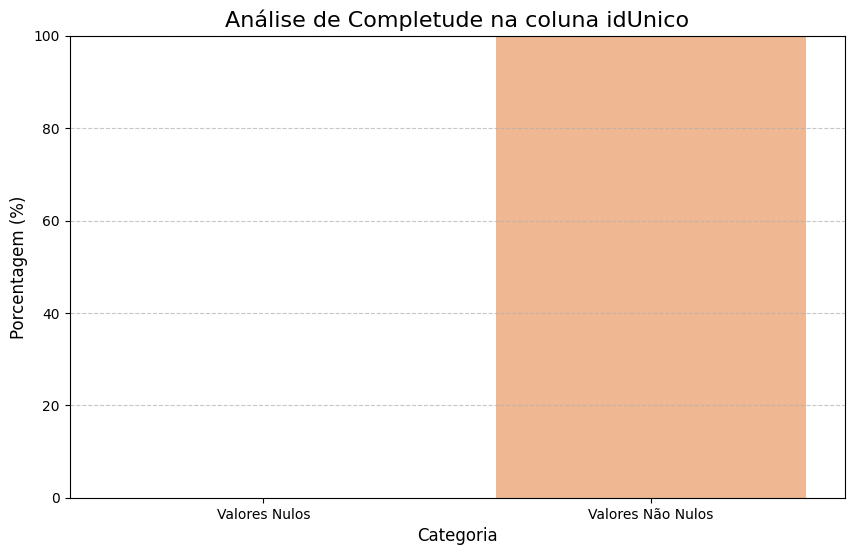

Coluna **idUnico** possui 750 valores preenchidos, correspondendo a 100.00% do total de registros.

Coluna **idUnico** possui 0 valores nulos, correspondendo a 0.00% do total de registros.

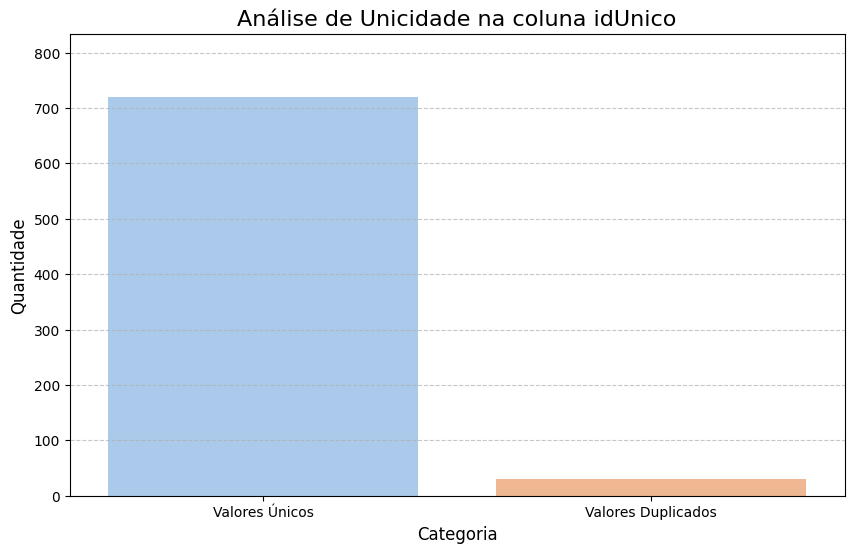

Coluna **idUnico** possui 719 valores únicos, correspondendo a 95.87% do total de registros.

Coluna **idUnico** possui 31 valores duplicados, correspondendo a 4.13% do total de registros.

In [6]:
coluna = 'idUnico'
completude_coluna, unicidade_coluna = verifica_coluna(coluna,df_limpa)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(completude_coluna.keys()), y=list(completude_coluna.values()), hue=list(completude_coluna.keys()), palette='pastel', legend=False)
plt.title(f'Análise de Completude na coluna {coluna}', fontsize=16)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(Markdown(f"Coluna **{coluna}** possui {completude_coluna['Valores Não Nulos']} valores preenchidos, correspondendo a {completude_coluna['Valores Não Nulos'] / df_limpa[coluna].count() * 100:.2f}% do total de registros."))
display(Markdown(f"Coluna **{coluna}** possui {completude_coluna['Valores Nulos']} valores nulos, correspondendo a {completude_coluna['Valores Nulos'] / df_limpa[coluna].count() * 100:.2f}% do total de registros."))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(unicidade_coluna.keys()), y=list(unicidade_coluna.values()), hue=list(unicidade_coluna.keys()), palette='pastel', legend=False)
plt.title(f'Análise de Unicidade na coluna {coluna}', fontsize=16)
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Categoria', fontsize=12)
plt.ylim(0, df[coluna].count())
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(Markdown(f"Coluna **{coluna}** possui {unicidade_coluna['Valores Únicos']} valores únicos, correspondendo a {unicidade_coluna['Valores Únicos'] / df_limpa[coluna].count() * 100:.2f}% do total de registros."))
display(Markdown(f"Coluna **{coluna}** possui {unicidade_coluna['Valores Duplicados']} valores duplicados, correspondendo a {unicidade_coluna['Valores Duplicados'] / df_limpa[coluna].count() * 100:.2f}% do total de registros."))

O primeiro resultado interessante que pode-se analizar, é que a partir do padrão dos 10 primeiros valores preenchidos nessa coluna, é possivel declarar que a melhor tipagem a se atribuir  é de fato `string`. O motivo para essa conclusão, é o fato de haver uma mesclagem entre caracteres alfanuméricos.

Após verificado o aspecto tipagem da coluna, a partir dos resultados é viável fazer mais algumas inferências sobre os dados. Os resultados demonstram que a coluna `idUnica` não assume completamente o papel de idenficador dentro da database, como presumia-se a princípio. Enquanto a coluna possui seus valores preenchidos integralmente, com uma taxa de nulidade equivalente a 0%, há um fato curioso que merece atenção:

-  **Resultado**: `Quantidade de valores duplicados na coluna [idUnico]: 31`

Todas os registros completamente clonados foram retirados para uma análise mais limpa, porém ainda sim há valores duplicados na coluna `idUnico`. Isto posto, primeiro será feita a conversão do tipo `object` para `string`. Após isso, mais alguns processos investigativos serão feitos com o objetivo de determinar o perfil dessas duplicatas.

In [7]:
# Conversão object -> string:
df_limpa['idUnico'] = df_limpa['idUnico'].astype('string')
print(f"Sucesso. Nova tipagem atribuída para a tabela [idUnico]: {df['idUnico'].dtype}")

# Verificação de duplicatas:
display((df_limpa[df_limpa['idUnico'].duplicated(keep=False)]['idUnico'].value_counts()).unique())
print(f"Frequência em que os casos de duplicatas ocorrem:\n {df_limpa[df_limpa['idUnico'].duplicated(keep=False)]['idUnico'].value_counts().value_counts()}")
display(df_limpa['idUnico'].duplicated(keep=False).value_counts())


Sucesso. Nova tipagem atribuída para a tabela [idUnico]: object


<IntegerArray>
[2]
Length: 1, dtype: Int64

Frequência em que os casos de duplicatas ocorrem:
 count
2    31
Name: count, dtype: Int64


idUnico
False    688
True      62
Name: count, dtype: int64

 O ultimo resultado trouxe mais algumas informações importantes acerca do perfil da coluna idUnico. Em síntese, tem-se que:
 - **Escala Original**: Foram identificados `31` idUnico distintos que possuem valores duplicados.
 - **Escala Total**: Ao total, indentificou-se `62` valores envolvidos nos casos de duplicatas (**Originais**: `31`, **Duplicatas**: `31`)
 - **Padrão dos Casos de Repetição**: Dentre os casos de duplicatas, descobriu-se que os valores de `idUnico` se repetem apenas `1` vez. Observa-se a proporção de 1:1.

Diante disso, sabe-se que muito provavelmente esses valores indicam algo sobre os padrões e regras de negócio aplicadas a database. Portanto, para encontrar mais detalhes sobre o contexto, o próximo passo é comparar paralelamente os registros duplicados, a fim de encontrar os campos modificados.

In [8]:
grupo_id_duplicados = (df_limpa[df_limpa['idUnico'].duplicated(keep=False)]).groupby('idUnico')
resumo_diference = []
for id_unico, grupo in grupo_id_duplicados:
    diference = grupo.iloc[0] != grupo.iloc[1]
    resumo_diference.append(diference)

df_resumo_diference = pd.DataFrame(resumo_diference)
df_resumo_diference.sum()

idUnico                                0
nome                                   0
cep                                   19
endereco                              18
descricao                              0
funcaoSocial                           0
metaGlobal                             0
dataInicialPrevista                    0
dataFinalPrevista                      0
dataInicialEfetiva                    29
dataFinalEfetiva                      30
dataCadastro                           0
especie                                0
natureza                               0
naturezaOutras                        28
situacao                               0
descPlanoNacionalPoliticaVinculado    24
uf                                     0
qdtEmpregosGerados                    29
descPopulacaoBeneficiada              29
populacaoBeneficiada                  29
observacoesPertinentes                31
isModeladaPorBim                       5
dataSituacao                           0
tomadores       

Os resultados acima apresentam informações sobre quantas vezes cada coluna foi modificada entre os 58 casos de duplicatas. 

No casos de clonagem da coluna `idUnico`, tem-se o registro original e o registro posterior, formando um par. Assim, levando em consideração os resultados coletados até o momento, é factível realizar a seguinte inferência:

- A primeira ocorrência de um idUnico representa o cadastro inicial, contendo as informações básicas da obra. A segunda ocorrência, que é criada utilizando o mesmo idUnico, funciona como uma atualização de status ou um registro de conclusão da obra. Os campos que contém a maior frequência de modificação durante esse processo são:
  
  - DataInicialEfetiva
  - DataFinalEfetiva
  - descPlanoNacionalPoliticaVinculado
  - qtdEmpregosGerados
  - descPopulacaoBeneficiada
  - observacoesPertinentes
  - subTipos


